In [1]:
from gensim import corpora, models, similarities
import pandas as pd
import gensim
import logging
from gensim import corpora
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
from nltk.tokenize import TweetTokenizer, word_tokenize
from gensim.test.utils import datapath
import re
import string

In [2]:
def get_tweets(twitter_handle):
    tweet_data = pd.read_csv('..//Tweets//' + twitter_handle + '_tweets.csv', encoding = 'utf-8')
    tweet_data = tweet_data.dropna()
    return tweet_data

tweets = get_tweets('ewarren')

In [3]:
# Changing &amp; to 'and'
tweets.text = tweets.text.apply(lambda x: re.sub(u'&amp;', u'and', x))

# extracting URLS
tweets.text = tweets.text.apply(lambda x: re.sub(u'http\\S+', u'', x)) 

In [4]:
corpus=[]
for i in range(len(tweets['text'])):
        a=tweets['text'][i]
        corpus.append(a)

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoticons = emoticons_happy.union(emoticons_sad)

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def clean_tweets(tweet):
 
    stop_words = set(stopwords.words('english') + list(punctuation) + ['RT','rt'])
    word_tokens = word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r'\&amp\;', 'and', tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return filtered_tweet
    #print(word_tokens)
    #print(filtered_sentence)return tweet

In [7]:
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1
tknzr = TweetTokenizer()

texts = [[word for word in clean_tweets(str(document).lower())] for document in corpus]

In [8]:
dictionary = corpora.Dictionary(texts)

2019-07-04 14:21:23,131 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-07-04 14:21:23,228 : INFO : built Dictionary(8426 unique tokens: ["'ll", "'m", 'commissions', 'different', 'districts']...) from 3200 documents (total 57947 corpus positions)


In [9]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [10]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2019-07-04 14:21:23,312 : INFO : collecting document frequencies
2019-07-04 14:21:23,314 : INFO : PROGRESS: processing document #0
2019-07-04 14:21:23,330 : INFO : calculating IDF weights for 3200 documents and 8426 features (54528 matrix non-zeros)


In [11]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [12]:
total_topics = 5

In [13]:
lda = models.LdaMulticore(corpus, id2word = dictionary, num_topics = total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2019-07-04 14:21:23,386 : INFO : using symmetric alpha at 0.2
2019-07-04 14:21:23,389 : INFO : using symmetric eta at 0.2
2019-07-04 14:21:23,392 : INFO : using serial LDA version on this node
2019-07-04 14:21:23,399 : INFO : running online LDA training, 5 topics, 1 passes over the supplied corpus of 3200 documents, updating every 6000 documents, evaluating every ~3200 documents, iterating 50x with a convergence threshold of 0.001000
2019-07-04 14:21:23,400 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-07-04 14:21:23,405 : INFO : training LDA model using 3 processes
2019-07-04 14:21:23,428 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3200, outstanding queue size 1
2019-07-04 14:21:23,452 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #3200/3200, outstanding queue size 2
2019-07-04 14:21:25,593 : INFO : topic #0 (0.200): 0.037*"’" + 0.008*"plan" + 0.007

In [14]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [15]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T

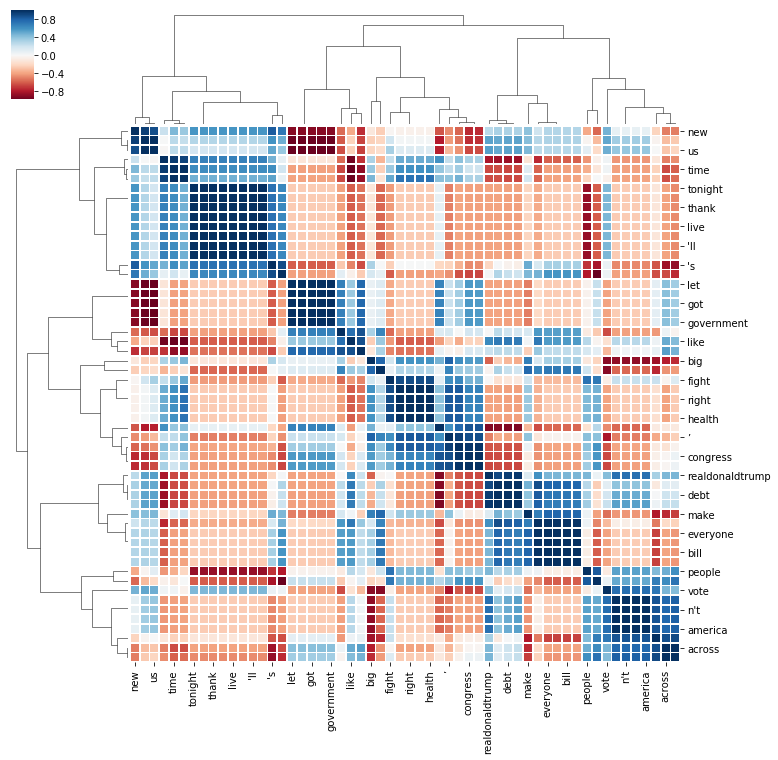

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [17]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
# panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
# panel

In [18]:
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       76.122437 -107.665108       1        1  28.673386
2      106.343285    2.304049       2        1  22.949665
3      152.743988  -71.868904       3        1  19.204588
4       -6.482472  -89.535362       4        1  16.063507
1       22.531446   -6.995246       5        1  13.108855, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
5223  Default   20.000000                –   20.000000  30.0000  30.0000
103   Default  107.000000                ’  107.000000  29.0000  29.0000
52    Default   19.000000               's   19.000000  28.0000  28.0000
253   Default    8.000000             care    8.000000  27.0000  27.0000
71    Default   21.000000           people   21.000000  26.0000  26.0000
2405  Default   10.000000  realdonaldtrump   10.000000  25.0000  25.0000
559   Default    6.000000             debt    6.000000  24.0000  24.0000
781   Default    3.000000             live    3.000000  23.0000  23.0000
56    Default    9.000000             back    9.000000  22.0000  22.0000
101   Default   10.000000               us   10.000000  21.0000  21.0000
3401  Default    1.000000               de    1.000000  20.0000  20.0000
565   Default    5.000000          student    5.000000  19.0000  19.0000
124   Default   14.000000          country   14.000000  18.0000  18.0000
180   Default    5.000000           health    5.000000  17.0000  17.0000
313   Default   12.000000              new   12.000000  16.0000  16.0000
130   Default    5.000000             work    5.000000  15.0000  15.0000
357   Default    4.000000          tonight    4.000000  14.0000  14.0000
85    Default   15.000000             make   15.000000  13.0000  13.0000
104   Default   13.000000              big   13.000000  12.0000  12.0000
562   Default    3.000000             loan    3.000000  11.0000  11.0000
83    Default    6.000000       grassroots    6.000000  10.0000  10.0000
137   Default   10.000000             help   10.000000   9.0000   9.0000
221   Default    8.000000            would    8.000000   8.0000   8.0000
88    Default   14.000000             plan   14.000000   7.0000   7.0000
643   Default    4.000000             bill    4.000000   6.0000   6.0000
277   Default    6.000000            women    6.000000   5.0000   5.0000
611   Default    6.000000         everyone    6.000000   4.0000   4.0000
361   Default    5.000000              win    5.000000   3.0000   3.0000
165   Default    5.000000             real    5.000000   2.0000   2.0000
181   Default    5.000000           public    5.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
93     Topic5    0.951534          economy    3.037119   0.8713  -6.0887
562    Topic5    1.132852             loan    3.804189   0.8205  -5.9143
2383   Topic5    0.370766           rigged    0.928356   1.1140  -7.0312
528    Topic5    0.483488             line    1.335580   1.0158  -6.7658
221    Topic5    2.029240            would    8.611341   0.5865  -5.3314
137    Topic5    2.355106             help   10.547131   0.5326  -5.1824
103    Topic5   13.043966                ’  107.588211  -0.0781  -3.4707
85     Topic5    2.965543             make   15.887877   0.3534  -4.9520
611    Topic5    1.569986         everyone    6.677933   0.5841  -5.5880
52     Topic5    3.428030               's   19.989737   0.2686  -4.8070
361    Topic5    1.266931              win    5.120207   0.6353  -5.8024
169    Topic5    0.829613             even    2.990422   0.7497  -6.2258
133    Topic5    1.818226           change    9.391301   0.3900  -5.4412
2405   Topic5    1.986079  realdonaldtrump   10.717422   0.3462  -5.3529
104    Topic5    2.184368              big   13.168444   0.2354  -5.2577
174    Topic5    1.792526             like    9